In [1]:
%reload_kedro

2023-03-12 10:59:23,486 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-12 10:59:25,016 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-12 10:59:25,173 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-12 10:59:25,174 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
import warnings
import numpy as np

/Users/guilhermepalazzo/anaconda3/envs/msc_thesis/lib/python3.8/site-packages/quantstats/reports.py:37: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import (
/Users/guilhermepalazzo/anaconda3/envs/msc_thesis/lib/python3.8/site-packages/quantstats/utils.py:297: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic("matplotlib inline")


In [3]:
plt.style.use("grayscale")
warnings.filterwarnings("ignore")

### Portfolio overall metrics

In [4]:
df_xgb_portf_metr = catalog.load("xgboost_portfolio_metrics")
df_xgb_portf_metr.loc[:, "model"] = "xgboost"

df_lstm_portf_metr = catalog.load("lstm_portfolio_metrics")
df_lstm_portf_metr.loc[:, "model"] = "lstm"

df_logreg_portf_metr = catalog.load("logistic_regr_portfolio_metrics")
df_logreg_portf_metr.loc[:, "model"] = "logreg"

df_benchm_metr = catalog.load("benchmark_metrics")
df_benchm_metr.loc[:, "model"] = "benchmark"

2023-03-12 10:59:26,765 - kedro.io.data_catalog - INFO - Loading data from `xgboost_portfolio_metrics` (ParquetDataSet)...
2023-03-12 10:59:26,839 - kedro.io.data_catalog - INFO - Loading data from `lstm_portfolio_metrics` (ParquetDataSet)...
2023-03-12 10:59:26,848 - kedro.io.data_catalog - INFO - Loading data from `logistic_regr_portfolio_metrics` (ParquetDataSet)...
2023-03-12 10:59:26,861 - kedro.io.data_catalog - INFO - Loading data from `benchmark_metrics` (ParquetDataSet)...


In [5]:
final_df = pd.concat([df_xgb_portf_metr, df_lstm_portf_metr, df_logreg_portf_metr, df_benchm_metr])
final_df = final_df.sort_values(by="annual_sharpe", ascending=False)

In [6]:
final_df

,annual_sharpe,profit_factor_pct,nominal_profit,annual_sortino,max_drawdown_pct,consecutive_wins,consecutive_losses,model
0,0.970373,1.210325,22016.280000,1.395008,-0.155866,10,5,benchmark
0,0.680984,1.108659,15272.826621,1.015852,-0.037816,5,8,xgboost
0,-1.224608,0.828027,-28078.013177,-1.573238,-0.054896,5,5,logreg
0,-11.198728,0.132596,-16229.772443,-10.216624,-0.054896,1,2,lstm


### Operations Profit over Time

In [7]:
df_xgb_portf_pnl = catalog.load("xgboost_portfolio_pnl")
df_lstm_portf_pnl = catalog.load("lstm_portfolio_pnl")
df_logreg_portf_pnl = catalog.load("logistic_regr_portfolio_pnl")
df_benchmark_portf_pnl = catalog.load("benchmark_pnl")

2023-03-12 10:59:26,974 - kedro.io.data_catalog - INFO - Loading data from `xgboost_portfolio_pnl` (ParquetDataSet)...
2023-03-12 10:59:27,000 - kedro.io.data_catalog - INFO - Loading data from `lstm_portfolio_pnl` (ParquetDataSet)...
2023-03-12 10:59:27,024 - kedro.io.data_catalog - INFO - Loading data from `logistic_regr_portfolio_pnl` (ParquetDataSet)...
2023-03-12 10:59:27,042 - kedro.io.data_catalog - INFO - Loading data from `benchmark_pnl` (ParquetDataSet)...


#### XGBoost

In [8]:
df_ops = df_xgb_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

In [9]:
accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

In [10]:
df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

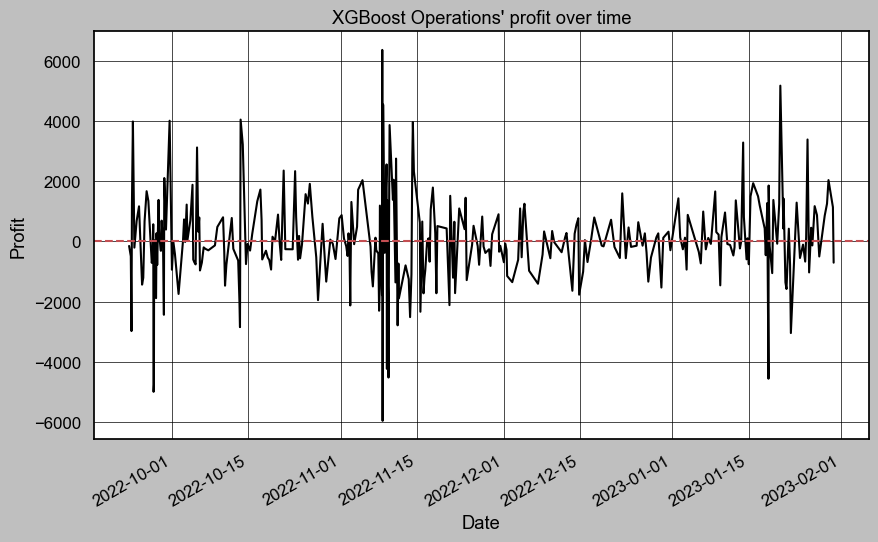

In [11]:
plot = df_ops[["close_time", "op_full_profit"]].set_index("close_time").sort_index(). \
                plot(title="XGBoost Operations' profit over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit"
                    )

plt.axhline(y=0.0, color='r', linestyle='--')

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_xgboost_ops_profit.png")

<AxesSubplot: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

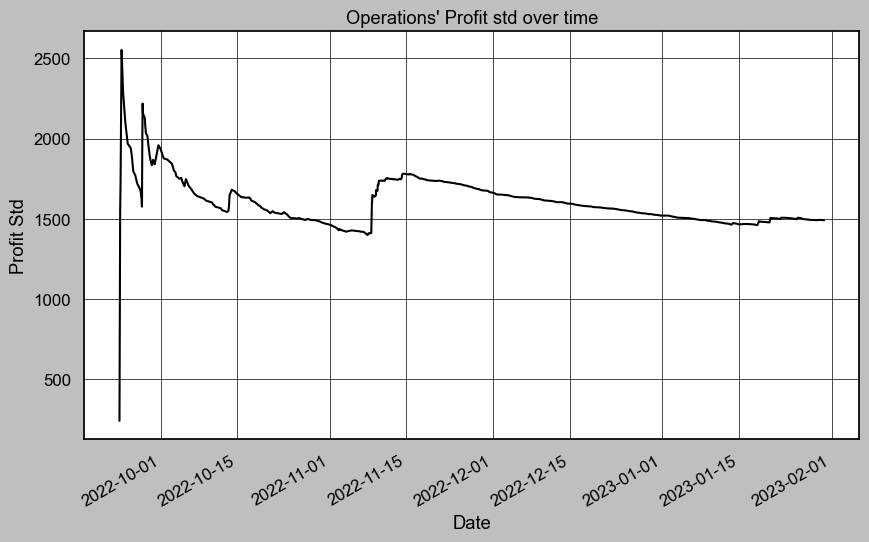

In [12]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<AxesSubplot: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

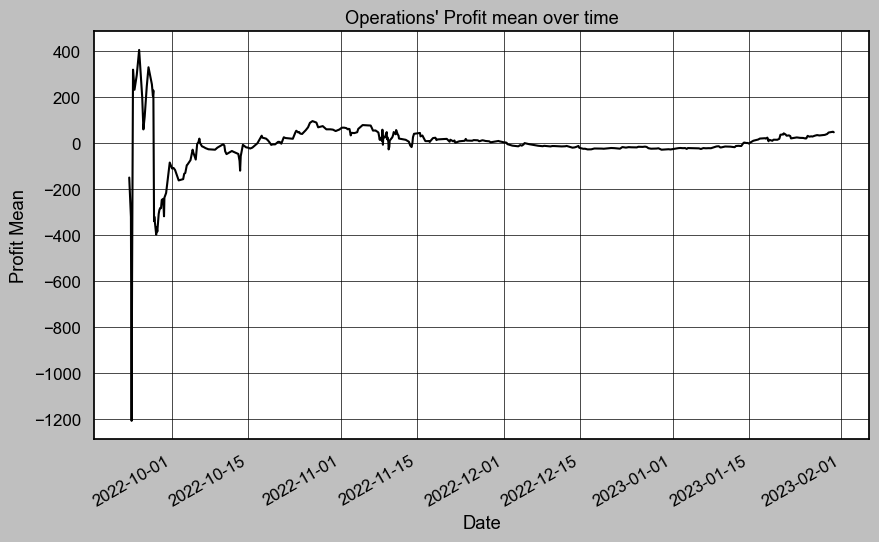

In [13]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

#### LSTM

In [14]:
df_ops = df_lstm_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

In [15]:
accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

In [16]:
df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

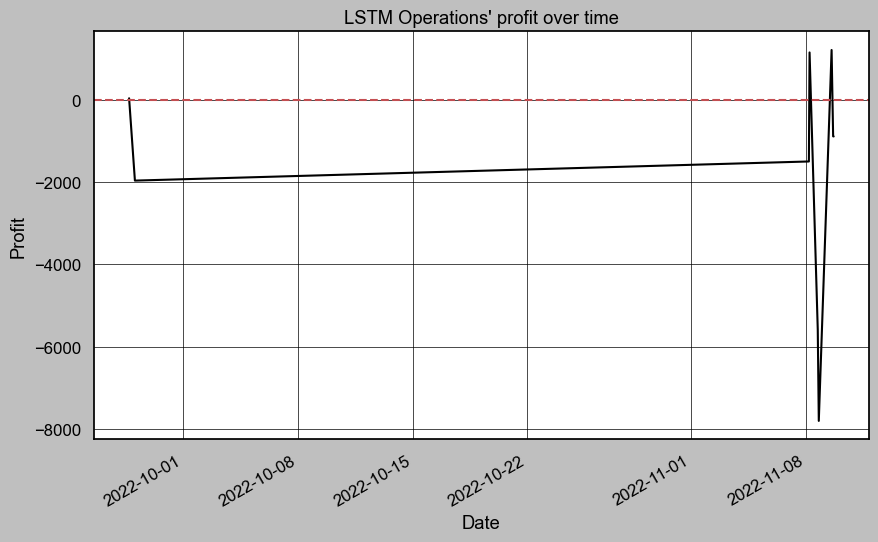

In [17]:
plot = df_ops[["close_time", "op_full_profit"]].set_index("close_time").sort_index(). \
                plot(title="LSTM Operations' profit over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit"
                    )

plt.axhline(y=0.0, color='r', linestyle='--')

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_lstm_ops_profit.png")

<AxesSubplot: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

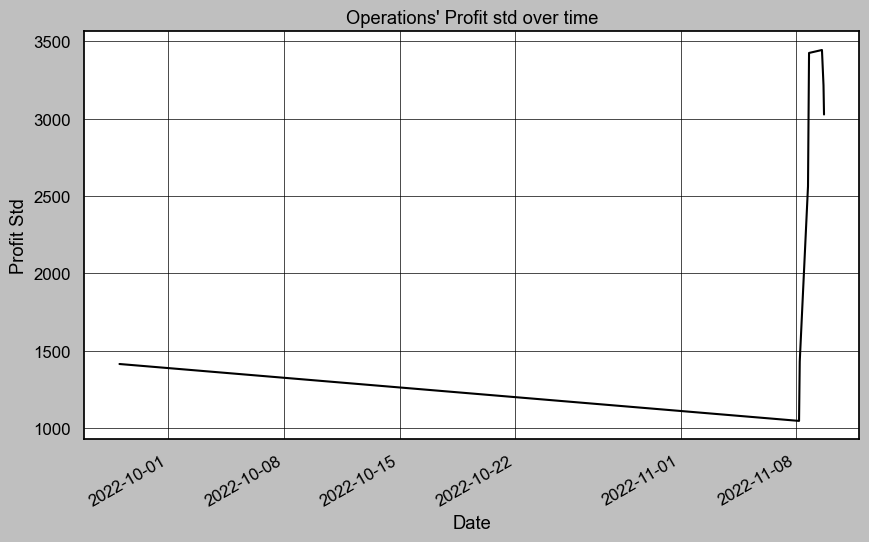

In [18]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<AxesSubplot: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

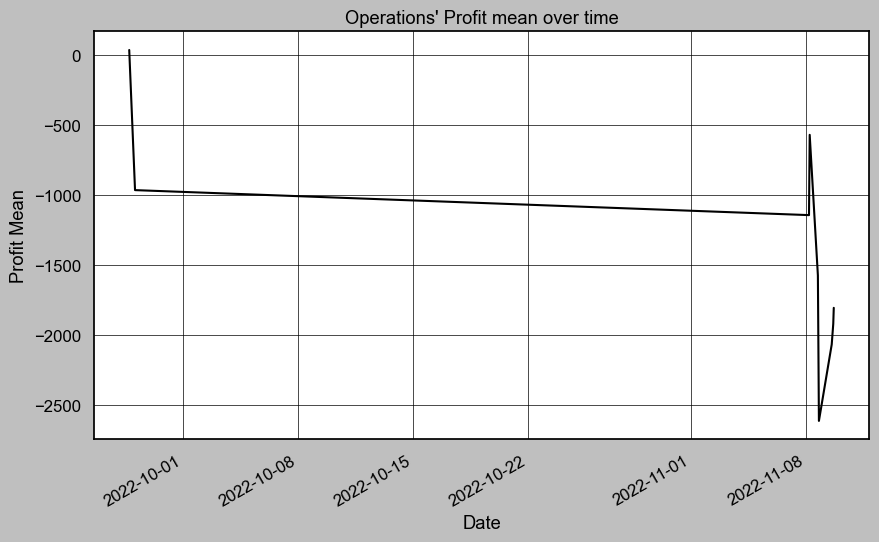

In [19]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

#### LogReg

In [20]:
df_ops = df_logreg_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

In [21]:
accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

In [22]:
df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

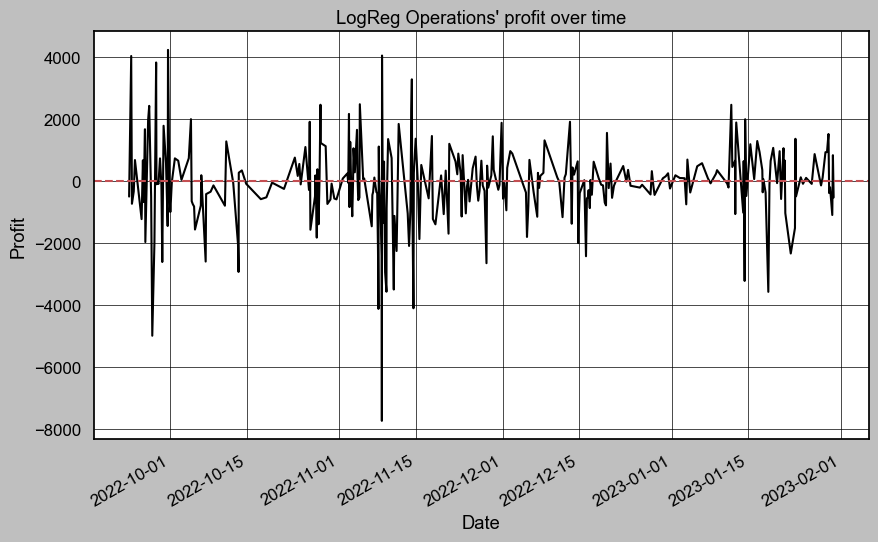

In [23]:
plot = df_ops[["close_time", "op_full_profit"]].set_index("close_time").sort_index(). \
                plot(title="LogReg Operations' profit over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit"
                    )

plt.axhline(y=0.0, color='r', linestyle='--')

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_logreg_ops_profit.png")

<AxesSubplot: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

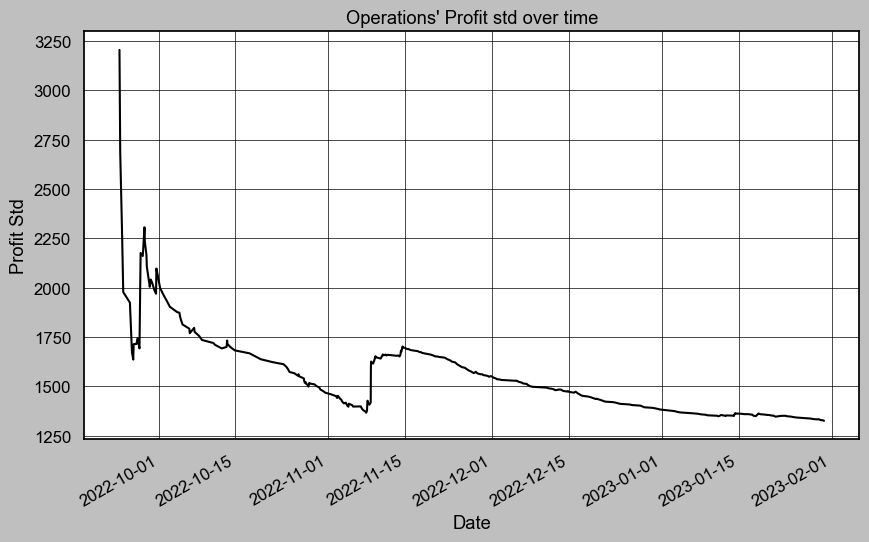

In [24]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<AxesSubplot: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

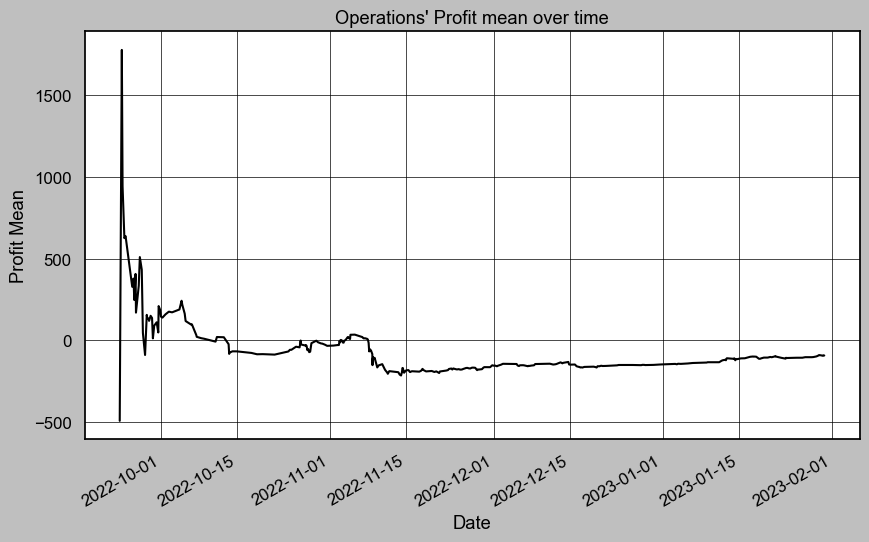

In [25]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

### QS plots

In [26]:
df_benchmark = df_benchmark_portf_pnl[["close_time", "pctchg_pos"]] \
                .rename(columns={"close_time": "date"}) \
                .set_index("date").sort_index()

df_benchmark.index = pd.to_datetime(df_benchmark.index)

#### XGBoost

In [63]:
df_logret = df_xgb_portf_pnl[["close_time", "logret_pos"]]
df_logret.loc[:, "date"] = df_logret["close_time"].dt.date

In [64]:
df_logret_daily = df_logret.groupby("date")["logret_pos"].sum()

df_pctchg_daily = np.exp(df_logret_daily) - 1
df_pctchg_daily.index = pd.to_datetime(df_pctchg_daily.index)

In [65]:
# full portfolio plot
df_pctchg_daily_portf = pd.DataFrame(df_pctchg_daily, index=df_pctchg_daily.index) \
                            .rename(columns={"logret_pos": "portf_pctchg_pos"})

df_pctchg_daily_benchm = pd.DataFrame(df_benchmark, index=df_benchmark.index) \
                            .rename(columns={"pctchg_pos": "benchm_pctchg_pos"})

df = df_pctchg_daily_portf.merge(df_pctchg_daily_benchm, left_index=True, right_index=True, how="left")

In [66]:
df = df.fillna(0)
df.head(10)

,portf_pctchg_pos,benchm_pctchg_pos
date,,
2022-09-23,0.010669,0.024135
2022-09-24,0.010861,0.000000
2022-09-25,-0.012853,0.000000
2022-09-26,0.019962,-0.008963
2022-09-27,-0.067035,0.014489
2022-09-28,-0.008929,-0.003902
2022-09-29,0.004514,0.003755
2022-09-30,0.021464,-0.009422
2022-10-01,-0.003029,0.000000


In [67]:
qs.reports.metrics(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, periods_per_year=360)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-09-23  2022-09-23
End Period          2023-01-30  2023-01-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      68.0%

Cumulative Return   10.18%      14.69%
CAGR﹪              31.57%      47.37%

Sharpe              1.22        0.96
Prob. Sharpe Ratio  76.01%      70.89%
Sortino             1.83        1.37
Sortino/√2          1.29        0.97
Omega               1.21        1.21

Max Drawdown        -10.11%     -31.07%
Longest DD Days     85          83

Gain/Pain Ratio     0.21        0.21
Gain/Pain (1M)      1.05        0.9

Payoff Ratio        1.52        0.82
Profit Factor       1.21        1.21
Common Sense Ratio  1.56        1.74
CPC Index           0.89        0.51
Tail Ratio          1.29        1.44
Outlier Win Ratio   6.55        4.93
Outlier Loss Ratio  8.62        3.02

MTD                 15.25%      35.14%
3M                  5.85%       3.08%

In [68]:
plot = qs.plots.returns(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, show=False)

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_xgboost_portf_vs_benchmk_rets.png")

#### LSTM

In [69]:
df_logret = df_lstm_portf_pnl[["close_time", "logret_pos"]]
df_logret.loc[:, "date"] = df_logret["close_time"].dt.date

In [70]:
df_logret_daily = df_logret.groupby("date")["logret_pos"].sum()

df_pctchg_daily = np.exp(df_logret_daily) - 1
df_pctchg_daily.index = pd.to_datetime(df_pctchg_daily.index)

In [71]:
# full portfolio plot
df_pctchg_daily_portf = pd.DataFrame(df_pctchg_daily, index=df_pctchg_daily.index) \
                            .rename(columns={"logret_pos": "portf_pctchg_pos"})

df_pctchg_daily_benchm = pd.DataFrame(df_benchmark, index=df_benchmark.index) \
                            .rename(columns={"pctchg_pos": "benchm_pctchg_pos"})

df = df_pctchg_daily_portf.merge(df_pctchg_daily_benchm, left_index=True, right_index=True, how="left")

In [72]:
df = df.fillna(0)
df.head(10)

,portf_pctchg_pos,benchm_pctchg_pos
date,,
2022-09-27,0.000249,0.014489
2022-09-28,-0.013085,-0.003902
2022-11-08,-0.092769,-0.130479
2022-11-09,-0.004224,0.129326


In [73]:
qs.reports.metrics(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, periods_per_year=360)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-09-27  2022-09-27
End Period          2022-11-09  2022-11-09
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -10.82%     -0.77%
CAGR﹪              -62.17%     -6.34%

Sharpe              -11.87      0.42
Prob. Sharpe Ratio  0.0%        51.53%
Sortino             -11.11      0.69
Sortino/√2          -7.86       0.48
Omega               0.0         0.0

Max Drawdown        -10.84%     -13.39%
Longest DD Days     42          42

Gain/Pain Ratio     -1.0        0.07
Gain/Pain (1M)      -1.0        8.18

Payoff Ratio        0.0         0.22
Profit Factor       0.0         1.07
Common Sense Ratio  0.0         1.08
CPC Index           0.0         0.12
Tail Ratio          0.01        1.01
Outlier Win Ratio   252.89      0.88
Outlier Loss Ratio  2.96        1.62

MTD                 -9.66%      -1.8%
3M                  -10.82%     -0.77

In [74]:
plot = qs.plots.returns(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, show=False)

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_lstm_portf_vs_benchmk_rets.png")

#### LogReg

In [75]:
df_logret = df_logreg_portf_pnl[["close_time", "logret_pos"]]
df_logret.loc[:, "date"] = df_logret["close_time"].dt.date

In [76]:
df_logret_daily = df_logret.groupby("date")["logret_pos"].sum()

df_pctchg_daily = np.exp(df_logret_daily) - 1
df_pctchg_daily.index = pd.to_datetime(df_pctchg_daily.index)

In [77]:
# full portfolio plot
df_pctchg_daily_portf = pd.DataFrame(df_pctchg_daily, index=df_pctchg_daily.index) \
                            .rename(columns={"logret_pos": "portf_pctchg_pos"})

df_pctchg_daily_benchm = pd.DataFrame(df_benchmark, index=df_benchmark.index) \
                            .rename(columns={"pctchg_pos": "benchm_pctchg_pos"})

df = df_pctchg_daily_portf.merge(df_pctchg_daily_benchm, left_index=True, right_index=True, how="left")

In [78]:
df = df.fillna(0)
df.head(10)

,portf_pctchg_pos,benchm_pctchg_pos
date,,
2022-09-23,0.018846,0.024135
2022-09-24,0.002355,0.000000
2022-09-25,-0.003526,0.000000
2022-09-26,0.006765,-0.008963
2022-09-27,-0.019778,0.014489
2022-09-28,0.010839,-0.003902
2022-09-29,-0.001291,0.003755
2022-09-30,0.013137,-0.009422
2022-10-01,0.004639,0.000000


In [79]:
qs.reports.metrics(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, periods_per_year=360)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-09-23  2022-09-23
End Period          2023-01-30  2023-01-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      67.0%

Cumulative Return   -18.72%     4.51%
CAGR﹪              -44.37%     13.3%

Sharpe              -2.12       0.54
Prob. Sharpe Ratio  9.0%        61.71%
Sortino             -2.43       0.74
Sortino/√2          -1.72       0.52
Omega               0.71        0.71

Max Drawdown        -28.1%      -31.07%
Longest DD Days     117         87

Gain/Pain Ratio     -0.29       0.11
Gain/Pain (1M)      -0.68       0.5

Payoff Ratio        0.52        0.87
Profit Factor       0.71        1.11
Common Sense Ratio  0.57        1.46
CPC Index           0.19        0.47
Tail Ratio          0.8         1.31
Outlier Win Ratio   6.44        3.75
Outlier Loss Ratio  6.76        3.33

MTD                 6.48%       22.12%
3M                  -18.27%     -5.28%


In [80]:
plot = qs.plots.returns(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, show=False)

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_logreg_portf_vs_benchmk_rets.png")